# Homework 5

**Due: 03/09/2018** (Friday 9th March at 11:59pm).

## Instructions

+ In any case, develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - you can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope. 

+ The total homework points are 100. Please note that the problems are not weighed equally.

**Note**: Please match all the pages corresponding to each of the questions when you submit on gradescope. 

## Student details

+ **First Name:**Gourav 
+ **Last Name:**Jhanwar
+ **Email:**gjhanwar@purdue.edu

## Readings

Before attempting the homework, it is probably a good idea to:
+ Review the slides of lectures 13 and 14; and
+ Review the corresponding lecture handouts.

$\newcommand{\x}{\mathbf{x}}$

In [26]:
import numpy as np
import scipy
import fipy
import GPy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

In [2]:
import numpy as np
import scipy

class KarhunenLoeveExpansion(object):
    
    """
    A class representing the Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Arguments:
        k      -     The covariance function.
        Xq     -     Quadrature points for the Nystrom approximation.
        wq     -     Quadrature weights for the Nystrom approximation.
        alpha  -     The percentage of the energy of the field that you want to keep.
        X      -     Observed inputs (optional).
        Y      -     Observed field values (optional).
    """
    
    def __init__(self, k, Xq=None, wq=None, nq=100, alpha=0.9, X=None, Y=None):
        self.k = k
        if Xq is None:
            if k.input_dim == 1:
                Xq = np.linspace(0, 1, nq)[:, None]
                wq = np.ones((nq, )) / nq
            elif k.input_dim == 2:
                nq = int(np.sqrt(nq))
                x = np.linspace(0, 1, nq)
                X1, X2 = np.meshgrid(x, x)
                Xq = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
                wq = np.ones((nq ** 2, )) / nq ** 2
            else:
                raise NotImplementedError('For more than 2D, please supply quadrature points and weights.')
        self.Xq = Xq
        self.wq = wq
        self.k = k
        self.alpha = alpha
        self.X = X
        self.Y = Y
        # If we have some observed data, we need to use the posterior covariance
        if X is not None:
            gpr = GPy.models.GPRegression(X, Y[:, None], k)
            gpr.likelihood.variance = 1e-12
            self.gpr = gpr
            Kq = gpr.predict(Xq, full_cov=True)[1]
        else:
            Kq = k.K(Xq)
        B = np.einsum('ij,j->ij', Kq, wq)
        lam, v = scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam[lam <= 0.] = 0.
        energy = np.cumsum(lam) / np.sum(lam)
        i_end = np.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        self.lam = lam
        self.sqrt_lam = np.sqrt(lam)
        self.v = v
        self.energy = energy
        self.num_xi = i_end
        
    def eval_phi(self, x):
        """
        Evaluate the eigenfunctions at x.
        """
        if self.X is not None:
            nq = self.Xq.shape[0]
            Xf = np.vstack([self.Xq, x])
            m, C = self.gpr.predict(Xf, full_cov=True)
            Kc = C[:nq, nq:].T
            self.tmp_mu = m[nq:, :].flatten()
        else:
            Kc = self.k.K(x, self.Xq)
            self.tmp_mu = 0.
        phi = np.einsum("i,ji,j,rj->ri", 1. / self.lam, self.v, self.wq**0.5, Kc)
        return phi
    
    def __call__(self, x, xi):
        """
        Evaluate the expansion at x and xi.
        """
        phi = self.eval_phi(x)
        return self.tmp_mu + np.dot(phi, xi * self.sqrt_lam)

class Elliptic2DSolver(object):
    def __init__(self, nx=100, ny=100, value_left=1.,
                 value_right=0., value_top=0., value_bottom=0.):
        """
        ::param nx:: Number of cells in the x direction.
        ::param ny:: Number of cells in the y direction.
        ::param value_left:: Boundary condition on the left face.
        ::param value_right:: Boundary condition on the right face.
        ::param value_top:: Boundary condition on the top face.
        ::param value_bottom:: Boundary condition on the bottom face.
        """
        #set domain dimensions
        self.nx = nx
        self.ny = ny
        self.dx = 1. / nx
        self.dy = 1. / ny
        
        #define mesh
        self.mesh = fipy.Grid2D(nx=self.nx, ny=self.ny, dx=self.dx, dy=self.dy)
        
        #get all the face centers 
        X, Y = self.mesh.faceCenters.value
        X = X[:, None]
        Y = Y[:, None]
        self.Xface = np.hstack([X,Y])

        #define cell and face variables 
        self.phi = fipy.CellVariable(name='$T(x)$', mesh=self.mesh, value=1.)
        self.C = fipy.FaceVariable(name='$C(x)$', mesh=self.mesh, value=1.)
        self.source=fipy.CellVariable(name='$f(x)$', mesh=self.mesh, value=0.)
        
        #apply boundary conditions
        #dirichet
        self.phi.constrain(value_left, self.mesh.facesLeft)
        self.phi.constrain(value_right, self.mesh.facesRight)
        
        #homogeneous Neumann
        self.phi.faceGrad.constrain(value_top, self.mesh.facesTop)
        self.phi.faceGrad.constrain(value_bottom, self.mesh.facesBottom)
        
        #setup the diffusion problem
        self.eq = -fipy.DiffusionTerm(coeff=self.C) == self.source
        
    def set_coeff(self, C):
        """
        Initialize the random conductivity field.
        """
        self.C.setValue(C)
    
    def solve(self):
        self.eq.solve(var=self.phi)
        #return self.phi.value
    
    def __call__(self):
        self.solve()
        return self.phi.value.flatten()

def sample(solver, kle, nsamples=1):
    """
    solver -> An object of the Elliptic2DSolver object. 
    kle -> An object of the KarhunenLoeveExpansion class.
    nsamples -> Number of samples of the PDE solution to generate.
    """
    samples = np.zeros((nsamples, solver.nx*solver.ny))
    maxn=solver.nx*solver.ny
    numxi = kle.num_xi
    I = np.ndarray((maxn,))    # A running estimate of the expecation
    V = np.ndarray((maxn,))    # A running estimate of the epistemic variance
    s = 0.                      # A variable to keep track of the sum
    s2 = 0.
    for i in xrange(nsamples):
        xi = np.random.randn(numxi)
        coeff = kle(solver.Xface, xi)
        solver.set_coeff(np.exp(coeff))
        sample = solver()
        samples[i] = sample
        s += samples[i]
        # The current approximation of the integral is
        I = s / (i + 1)
        # Update s2:
        s2 += (samples[i] - I) ** 2
        # The current approximation of the epistemic variance
        V = s2 / (i + 1)
    return samples,I,V

# Problem 1 - Uncertainty propagation in 2-D stochastic elliptic partial differential equation

In lecture 13, we discussed the Monte Carlo method as a technique to compute high-dimensional integrals and used this technique to propagate uncertainties through physical models. 

Consider the following partial differential equation:

$$
\nabla (a(\x) \nabla u(\x)) = 0, \ \forall \x \in [0, 1]^2,
$$
with boundary conditions:
$$
u|_{x_1 = 0} = 1, \\
u|_{x_1 = 1} = 0, \\
\frac{\partial u}{\partial n}|_{x_2 = 0} = 0, \\
\frac{\partial u}{\partial n}|_{x_2 = 1} = 0.
$$

This is a general model for diffusion problems and shows up in a wide variety of applications, such as heat conduction, subsurface flows, electromagnetics etc. It is often the case that one is uncertain about the diffusion coefficient $a$. Suppose it is known that $a$ is a positive quantity and it varies with lengthscales 0.1 and 0.5 along the two spatial directions. Assume that $a$ is a smooth quantity and has unit variance.

### Part a.

Pose the diffusion coefficient as a transformed Gaussian random field. Use the Karhunen-Loeve expansion to obtain a reduced representation of $a$. Make sure you use enough quadrature points for the KLE.  

Number of terms: 26


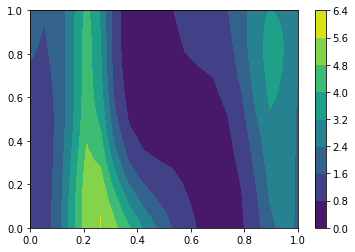

In [3]:
dim = 2
# The variance of the covariance kernel
variance = 1
# The lengthscale of the covariance kernel
ell1= 0.1
ell2= 0.5
k = GPy.kern.RBF(dim, ARD=True, variance=variance, lengthscale=[ell1,ell2])
kle = KarhunenLoeveExpansion(k, nq=1000, alpha=0.99)
nx=20
ny=20
x1 = np.linspace(0, 1, nx)
x2= np.linspace(0, 1, ny)
X1, X2 = np.meshgrid(x1, x2)
X_all = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
print 'Number of terms:', kle.num_xi
xi = np.random.randn(kle.num_xi)
f =np.exp(kle(X_all, xi).reshape(X1.shape))
fig, ax = plt.subplots()
c = ax.contourf(X1, X2,f)
plt.colorbar(c)

### Part b.

The class ```Elliptic2DSolver``` defined at the top of this notebook can be used to solve this PDE. Additionally, we have provided a function ```sample``` to generate as many samples of the stochastic PDE solution as you want. 

Establish the ground truth on the mean and variance of the solution $u$ of the PDE using 100000 Monte Carlo samples of the uncertain diffusion field. Show contour plots for mean and 2 standard deviation fields of the solution.

In [14]:
solver = Elliptic2DSolver(nx=20, ny=20, value_left=1.,value_right=0., value_top=0., value_bottom=0.)
sam,I,V = sample(solver, kle, nsamples=10000)

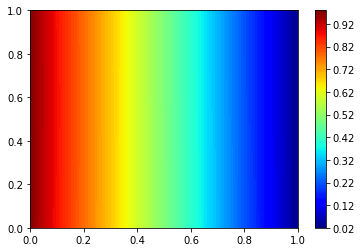

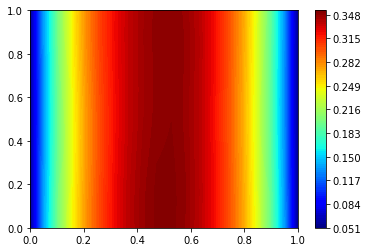

In [15]:
fig, ax = plt.subplots()
c = ax.contourf(X1, X2,I.reshape(X1.shape),100,cmap='jet')
plt.colorbar(c)
fig, ax = plt.subplots()
c = ax.contourf(X1, X2, 2.*np.sqrt(V.reshape(X1.shape)),100,cmap='jet')
plt.colorbar(c)

### Part c.

Propagate uncertainty through the model using 10, 100, 1,000, and 10,000 MC samples and plot the *relative* L2 error in the estimation of the mean and the variance. The relative L2 error is defined as follows:

##### Relative L2 Error
Let $\mathbf{y}_{\mbox{true}}$ be the *ground truth vector* and $\hat{\mathbf{y}}$ be the *estimated vector*.
The relattive L2 error is defined to be:
$$
L_2[\mathbf{y}_{\mbox{true}},\hat{\mathbf{y}}] = \frac{\parallel\mathbf{y}_{\mbox{true}}-\hat{\mathbf{y}} \parallel_2}{\parallel \mathbf{y}_{\mbox{true}}\parallel_2},
$$
where $\parallel\cdot\parallel_2$ is the standard Euclidean norm.


In [18]:
np.save('Itru', I)
np.save('Vtru', V)
Itrue=np.load('Itru.npy')
Vtrue=np.load('Vtru.npy')

In [20]:
n_samples=[10,100,1000]
L2_m_error= np.ndarray((np.size(n_samples),))
L2_v_error= np.ndarray((np.size(n_samples),))
for i in xrange(np.size(n_samples)):
    solver = Elliptic2DSolver(nx=20, ny=20, value_left=1.,value_right=0., value_top=0., value_bottom=0.)
    [sample_n,I_n,V_n] = sample(solver, kle, nsamples=n_samples[i])
    L2_m_error[i]= np.linalg.norm(Itrue-I_n)/np.linalg.norm(Itrue)
    print "L2 mean error for",n_samples[i],"samples",L2_m_error[i]
    L2_v_error[i]= np.linalg.norm(Vtrue-V_n)/np.linalg.norm(Vtrue)
    print "L2 variance error",n_samples[i],"samples",L2_v_error[i]
    

L2 mean error for 10 samples 0.0664588774242
L2 variance error 10 samples 0.173098707081
L2 mean error for 100 samples 0.0380806308703
L2 variance error 100 samples 0.11248647925
L2 mean error for 1000 samples 0.00318007343056
L2 variance error 1000 samples 0.0404274748197


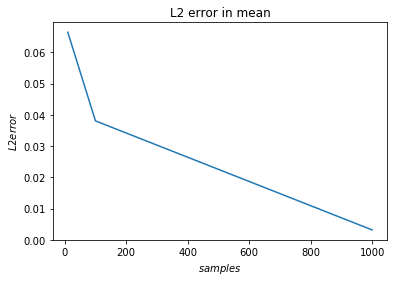

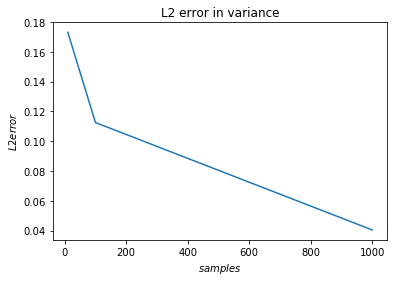

In [22]:
fig,ax0=plt.subplots()
ax0.plot(n_samples,L2_m_error,label='L2 error mean')
ax0.set_title('L2 error in mean')
ax0.set_xlabel('$samples$')
ax0.set_ylabel('$L2 error$')
fig,ax1=plt.subplots()
ax1.plot(n_samples,L2_v_error,label='L2 error variance')
ax1.set_title('L2 error in variance')
ax1.set_xlabel('$samples$')
ax1.set_ylabel('$L2 error$')

### Part d.

Repeat c. 100 times (if it takes too much time do 10) to get the uncertainty induced by the fact that MC estimates are noisy. You can use the function [numpy.percentile](http://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html) to get lower and upper uncertainty bars for the evolution of the L2 error.

In [23]:
L2_mean_error= np.ndarray((10,np.size(n_samples)))
L2_variance_error= np.ndarray((10,np.size(n_samples),))
for j in xrange(10):
    for i in xrange(np.size(n_samples)):
        solver = Elliptic2DSolver(nx=20, ny=20, value_left=1.,value_right=0., value_top=0., value_bottom=0.)
        [sample_n,I_n,V_n] = sample(solver, kle, nsamples=n_samples[i])
        L2_mean_error[j,i]= np.linalg.norm(Itrue-I_n)/np.linalg.norm(Itrue)
        #print "L2 mean error",L2_m_error[i]
        L2_variance_error[j,i]= np.linalg.norm(Vtrue-V_n)/np.linalg.norm(Vtrue)
        #print "L2 variance error",L2_v_error[i]

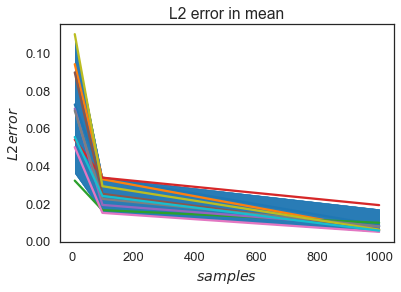

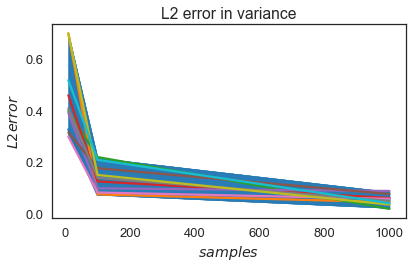

In [34]:
mean25 = np.percentile(L2_mean_error, 2.5, axis=0)
mean975 = np.percentile(L2_mean_error, 97.5, axis=0)
var25 = np.percentile(L2_variance_error, 2.5, axis=0)
var975 = np.percentile(L2_variance_error, 97.5, axis=0)
fig,ax0=plt.subplots()
fig,ax1=plt.subplots()
for k in range(10):
    ax0.plot(n_samples,L2_mean_error[k,:],label='L2 error mean')
    ax0.set_title('L2 error in mean')
    ax0.fill_between(n_samples, mean25, mean975, color=sns.color_palette()[0], alpha=0.25)
    ax1.plot(n_samples,L2_variance_error[k,:],label='L2 error variance')
    ax1.fill_between(n_samples, var25, var975, color=sns.color_palette()[0], alpha=0.25)
    ax1.set_title('L2 error in variance')
    ax0.set_xlabel('$samples$')
    ax0.set_ylabel('$L2 error$')
    ax1.set_xlabel('$samples$')
    ax1.set_ylabel('$L2 error$')
    plt.tight_layout()

# Problem 2  - Latin hypercube sampling (LHS)


Repeat the tasks in problem 1 parts (b), (c) and (d) with Latin hypercube sampling (LHS). Compare the LHS results with MCS results.

#### Hint:
Recall that we has used the Latin Hypercube sampler in class to generate uniform samples in the unit square - $[0, 1]^2$. It is trivial to transform these uniform samples into standard normal distributed samples. We just need the inverse CDF method discussed in Lecture 5. Also recall, from homework 2, that ```scipy.stat.norm.ppf``` implements the inverse CDF of the standard normal random variable. 

In [35]:
from scipy.stats import norm
import design
def sample_lhs(solver, kle, nsamples=1):
    """
    solver -> An object of the Elliptic2DSolver object. 
    kle -> An object of the KarhunenLoeveExpansion class.
    nsamples -> Number of samples of the PDE solution to generate.
    """
    samples = np.zeros((nsamples, solver.nx*solver.ny))
    maxn=solver.nx*solver.ny
    numxi = kle.num_xi
    I_lhs = np.ndarray((maxn,))    # A running estimate of the expecation
    V_lhs= np.ndarray((maxn,))    # A running estimate of the epistemic variance
    s = 0.                      # A variable to keep track of the sum
    s2 = 0.
    X = design.latin_center(nsamples,numxi)
    for i in xrange(nsamples):
        xi=norm.ppf(X[i,:])
        coeff = kle(solver.Xface, xi)
        solver.set_coeff(np.exp(coeff))
        sample = solver()
        samples[i] = sample
        s += samples[i]
        # The current approximation of the integral is
        I_lhs = s / (i + 1)
        # Update s2:
        s2 += (samples[i] - I_lhs) ** 2
        # The current approximation of the epistemic variance
        V_lhs = s2 / (i + 1)
    return samples,I_lhs,V_lhs

In [38]:
solver = Elliptic2DSolver(nx=20, ny=20, value_left=1.,value_right=0., value_top=0., value_bottom=0.)
sam,I_lhs,V_lhs = sample_lhs(solver, kle, nsamples=10000)

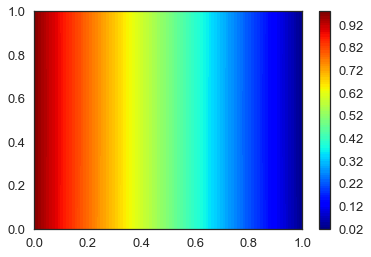

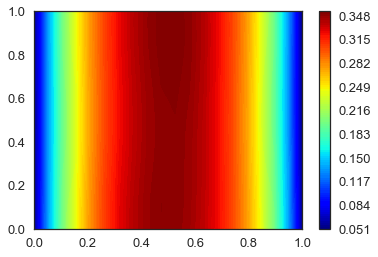

In [39]:
fig, ax = plt.subplots()
c = ax.contourf(X1, X2,I_lhs.reshape(X1.shape),100,cmap='jet')
plt.colorbar(c)
fig, ax = plt.subplots()
c = ax.contourf(X1, X2, 2.*np.sqrt(V_lhs.reshape(X1.shape)),100,cmap='jet')
plt.colorbar(c)

In [46]:
np.save('Itru_lhs', I_lhs)
np.save('Vtru_lhs', V_lhs)
Itrue_lhs=np.load('Itru_lhs.npy')
Vtrue_lhs=np.load('Vtru_lhs.npy')

In [47]:
n_samples=[10,100,1000]
L2_m_error_lhs= np.ndarray((np.size(n_samples),))
L2_v_error_lhs= np.ndarray((np.size(n_samples),))
for i in xrange(np.size(n_samples)):
    solver = Elliptic2DSolver(nx=20, ny=20, value_left=1.,value_right=0., value_top=0., value_bottom=0.)
    [sample_n,I_n,V_n] = sample_lhs(solver, kle, nsamples=n_samples[i])
    L2_m_error_lhs[i]= np.linalg.norm(Itrue_lhs-I_n)/np.linalg.norm(Itrue_lhs)
    print "L2 mean error for",n_samples[i],"samples",L2_m_error_lhs[i]
    L2_v_error_lhs[i]= np.linalg.norm(Vtrue_lhs-V_n)/np.linalg.norm(Vtrue_lhs)
    print "L2 variance error",n_samples[i],"samples",L2_v_error_lhs[i]

L2 mean error for 10 samples 0.0370655677175
L2 variance error 10 samples 0.431948068172
L2 mean error for 100 samples 0.043875776009
L2 variance error 100 samples 0.102778552427
L2 mean error for 1000 samples 0.0142987555907
L2 variance error 1000 samples 0.0343728870863


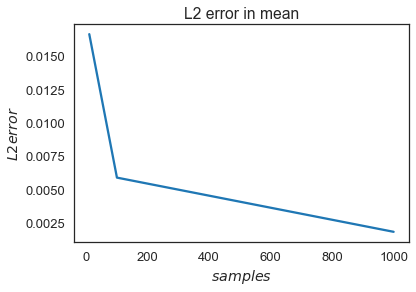

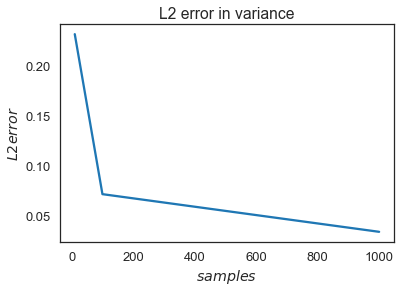

In [48]:
fig,ax0=plt.subplots()
ax0.plot(n_samples,L2_m_error_lhs,label='L2 error mean')
ax0.set_title('L2 error in mean')
ax0.set_xlabel('$samples$')
ax0.set_ylabel('$L2 error$')
fig,ax1=plt.subplots()
ax1.plot(n_samples,L2_v_error_lhs,label='L2 error variance')
ax1.set_title('L2 error in variance')
ax1.set_xlabel('$samples$')
ax1.set_ylabel('$L2 error$')

In [49]:
L2_mean_error_lhs= np.ndarray((10,np.size(n_samples)))
L2_variance_error_lhs= np.ndarray((10,np.size(n_samples),))
for j in xrange(10):
    for i in xrange(np.size(n_samples)):
        solver = Elliptic2DSolver(nx=20, ny=20, value_left=1.,value_right=0., value_top=0., value_bottom=0.)
        [sample_n,I_n,V_n] = sample(solver, kle, nsamples=n_samples[i])
        L2_mean_error_lhs[j,i]= np.linalg.norm(Itrue_lhs-I_n)/np.linalg.norm(Itrue_lhs)
        #print "L2 mean error",L2_m_error[i]
        L2_variance_error_lhs[j,i]= np.linalg.norm(Vtrue_lhs-V_n)/np.linalg.norm(Vtrue_lhs)
        #print "L2 variance error",L2_v_error[i]

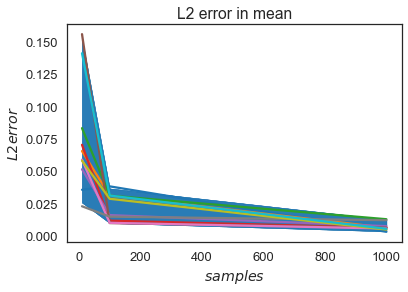

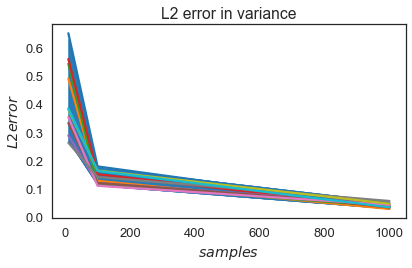

In [50]:
meanh25 = np.percentile(L2_mean_error_lhs, 2.5, axis=0)
meanh975 = np.percentile(L2_mean_error_lhs, 97.5, axis=0)
varh25 = np.percentile(L2_variance_error_lhs, 2.5, axis=0)
varh975 = np.percentile(L2_variance_error_lhs, 97.5, axis=0)
fig,ax0=plt.subplots()
fig,ax1=plt.subplots()
for k in range(10):
    ax0.plot(n_samples,L2_mean_error_lhs[k,:],label='L2 error mean')
    ax0.set_title('L2 error in mean')
    ax0.fill_between(n_samples, meanh25, meanh975, color=sns.color_palette()[0], alpha=0.25)
    ax1.plot(n_samples,L2_variance_error_lhs[k,:],label='L2 error variance')
    ax1.fill_between(n_samples, varh25, varh975, color=sns.color_palette()[0], alpha=0.25)
    ax1.set_title('L2 error in variance')
    ax0.set_xlabel('$samples$')
    ax0.set_ylabel('$L2 error$')
    ax1.set_xlabel('$samples$')
    ax1.set_ylabel('$L2 error$')
    plt.tight_layout()

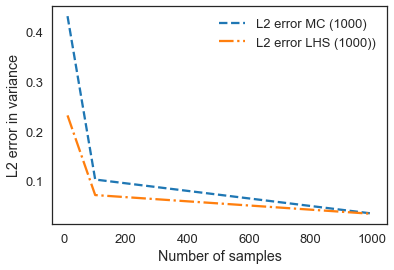

In [57]:
#print V.shape
#plt.plot(solver.t, V_y(solver.t), label='True variance')
plt.plot(n_samples, L2_v_error, '--', label='L2 error MC (1000)')
plt.plot(n_samples, L2_v_error_lhs, '-.', label='L2 error LHS (1000))')
plt.xlabel("Number of samples")
plt.ylabel("L2 error in variance")
plt.legend(loc='best')

As we can see from the above graph that for the few samples, Latin hypercube design samples wins over the monte carlo simulation samples since L2 error in variance is less in LHS samples. But as the number of samples goes high, monte carlo simulation wins over the the latin hyper cube samples since the rate of decrease in error in monte carlo simulation is greater than latin hypercube samples